<a href="https://colab.research.google.com/github/Rewanthnayak/Jupyer_notebooks/blob/main/break_his_ViT_80.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data Loading

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os

In [3]:
os.listdir('/content/drive/MyDrive/Cancer80/')

['Cancer_train', 'Cancer_test', 'Cancer_validation']

In [4]:
from tqdm.auto import tqdm
import os
def get_image_list(folder_path):
    image_list = []
    for subfolder in os.listdir(folder_path):
        if os.path.isdir(os.path.join(folder_path, subfolder)):
            label = 0 if subfolder == 'benign' else 1
            subfolder_path = os.path.join(folder_path, subfolder)
            for image_file in tqdm(os.listdir(subfolder_path)):
                if image_file.endswith('.png'):
                    image_path = os.path.join(subfolder_path, image_file)
                    image_list.append((image_path, label))
    return image_list


In [5]:
train_data = get_image_list("/content/drive/MyDrive/Cancer80/Cancer_train")
test_data = get_image_list("/content/drive/MyDrive/Cancer80/Cancer_test")
val_data = get_image_list("/content/drive/MyDrive/Cancer80/Cancer_validation")

  0%|          | 0/4404 [00:00<?, ?it/s]

  0%|          | 0/4404 [00:00<?, ?it/s]

  0%|          | 0/274 [00:00<?, ?it/s]

  0%|          | 0/517 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

In [6]:
# Print the sizes of the resulting sets
print("Train set size: ", len(train_data))
print("Validation set size: ", len(val_data))
print("Test set size: ", len(test_data))


Train set size:  8808
Validation set size:  712
Test set size:  791


In [7]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc, roc_curve, roc_auc_score,precision_recall_fscore_support
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Set the GPU to use
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

# Configure the GPU memory growth
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)


In [8]:
# Set parameters for loading images
batch_size = 64
img_height = 75
img_width = 75
num_classes = 2
# Assuming the list of tuples for train, val and test data are named `train_data`, `val_data` and `test_data` respectively
train_paths, train_labels = zip(*train_data)
train_paths = list(train_paths)
train_labels = list(train_labels)

val_paths, val_labels = zip(*val_data)
val_paths = list(val_paths)
val_labels = list(val_labels)

test_paths, test_labels = zip(*test_data)
test_paths = list(test_paths)
test_labels = list(test_labels)

# Load images from dataset variable and create batches for train, val, and test
train_dataset = tf.data.Dataset.from_tensor_slices((train_paths,train_labels))
train_dataset = train_dataset.shuffle(buffer_size=len(train_dataset))

val_dataset = tf.data.Dataset.from_tensor_slices((val_paths,val_labels))
val_dataset = val_dataset.shuffle(buffer_size=len(val_data))

test_dataset = tf.data.Dataset.from_tensor_slices((test_paths,test_labels))
test_dataset = test_dataset.shuffle(buffer_size=len(test_data))

# Define a function to load the images
# def load_image(image_path, label):
#     image = tf.io.read_file(image_path)
#     image = tf.image.decode_jpeg(image, channels=3)
#     image = tf.image.resize(image, (img_height, img_width))
#     return image, label

def load_image(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, (img_height, img_width)) # reshape
    image = tf.image.convert_image_dtype(image, tf.float32)
    # image = image / 255.0
    # image = tf.repeat(image, 3, axis=-1) # repeat the image on the 3rd axis to make it 3D
    return image, label


train_dataset = train_dataset.map(load_image)
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

val_dataset = val_dataset.map(load_image)
val_dataset = val_dataset.batch(batch_size)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

test_dataset = test_dataset.map(load_image)
test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

## InceptionResNetV2

In [9]:
import tensorflow as tf
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2


# Load pre-trained InceptionResNetV2 model
model = InceptionResNetV2(
    input_shape=(img_height, img_width, 3),
    weights='imagenet',
    include_top=False
)

# Make the model trainable
for layer in model.layers:
    layer.trainable = True

# Add custom output layers
x = model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dropout(0.3)(x)
predictions = tf.keras.layers.Dense(1, activation='sigmoid')(x)

# Compile the model
model = tf.keras.Model(inputs=model.input, outputs=predictions)

219055592/219055592 [==============================] - 1s 0us/step


In [10]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.BinaryCrossentropy(name='log_loss'),
        tf.keras.metrics.AUC(name='auc'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
            ]
)

In [11]:
# Set up  stopping and model checkpoint
earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint('/content/final_data/best_model_inceptionresnetv2.h5',\
                                                         monitor='val_loss', save_best_only=True, verbose=1)

# Train model on training set
history = model.fit(
    train_dataset,
    epochs=40,
    validation_data=val_dataset,
    callbacks=[earlystop_callback, checkpoint_callback]
)

Epoch 1/40
138/138 [==============================] - ETA: 0s - loss: 0.3838 - accuracy: 0.8564 - log_loss: 0.3838 - auc: 0.9294 - precision: 0.8507 - recall: 0.8644
Epoch 1: val_loss improved from inf to 0.79140, saving model to /content/final_data/best_model_inceptionresnetv2.h5
138/138 [==============================] - 896s 5s/step - loss: 0.3838 - accuracy: 0.8564 - log_loss: 0.3838 - auc: 0.9294 - precision: 0.8507 - recall: 0.8644 - val_loss: 0.7914 - val_accuracy: 0.7205 - val_log_loss: 0.7914 - val_auc: 0.7808 - val_precision: 0.7185 - val_recall: 1.0000
Epoch 2/40
138/138 [==============================] - ETA: 0s - loss: 0.2151 - accuracy: 0.9369 - log_loss: 0.2151 - auc: 0.9757 - precision: 0.9387 - recall: 0.9348
Epoch 2: val_loss improved from 0.79140 to 0.24150, saving model to /content/final_data/best_model_inceptionresnetv2.h5
138/138 [==============================] - 124s 899ms/step - loss: 0.2151 - accuracy: 0.9369 - log_loss: 0.2151 - auc: 0.9757 - precision: 0.938

In [18]:
print(history.history)

{'loss': [0.3837992250919342, 0.21506743133068085, 0.14104385673999786, 0.11231181770563126, 0.07223325222730637, 0.06890504062175751, 0.035815730690956116, 0.038220103830099106, 0.029610328376293182, 0.035233695060014725, 0.05102996528148651], 'accuracy': [0.8563805818557739, 0.936875581741333, 0.961398720741272, 0.9683242440223694, 0.9775204062461853, 0.9822888374328613, 0.9897820353507996, 0.9921662211418152, 0.990690290927887, 0.9910308718681335, 0.9849001169204712], 'log_loss': [0.3837992250919342, 0.21506743133068085, 0.14104385673999786, 0.11231181770563126, 0.07223325222730637, 0.06890504062175751, 0.035815730690956116, 0.038220103830099106, 0.029610328376293182, 0.035233695060014725, 0.05102996528148651], 'auc': [0.9294263124465942, 0.9756666421890259, 0.9875980615615845, 0.9919210076332092, 0.9963660836219788, 0.9967920780181885, 0.9991392493247986, 0.9988483190536499, 0.9990258812904358, 0.9981731176376343, 0.9979557394981384], 'precision': [0.8507262468338013, 0.93866848945

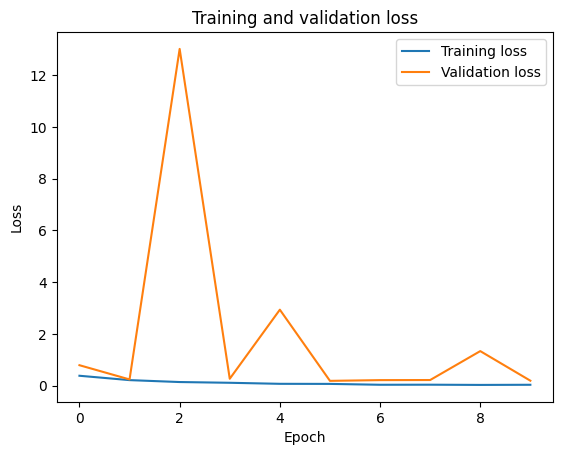

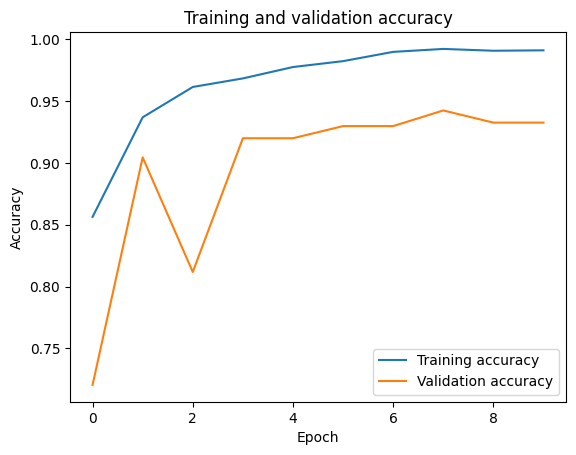

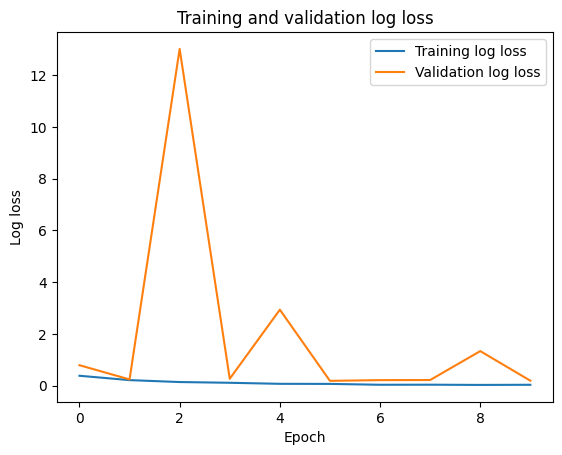

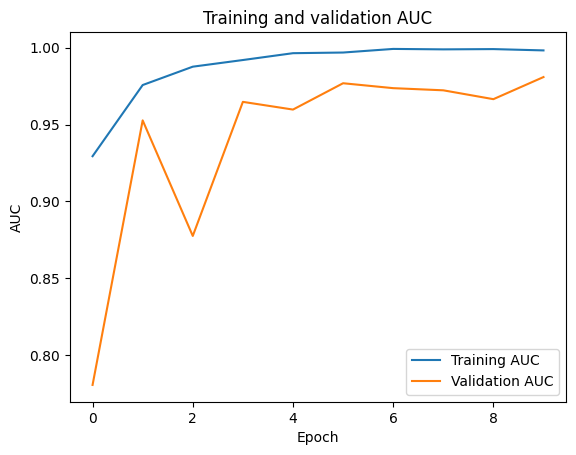

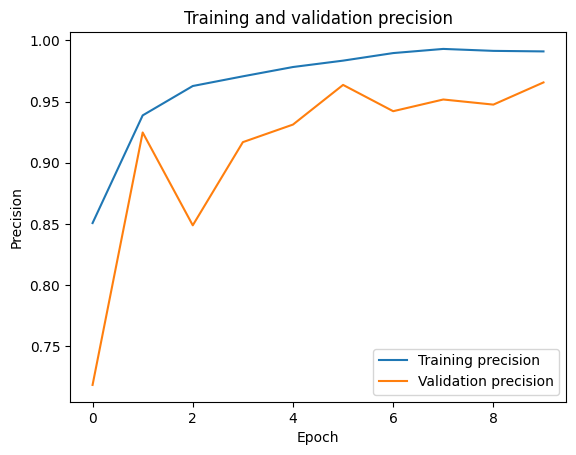

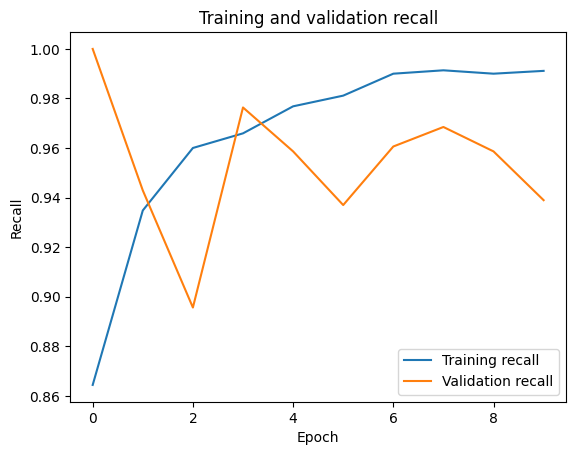

In [19]:
import matplotlib.pyplot as plt

# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracy
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot the training and validation log loss
plt.plot(history.history['log_loss'], label='Training log loss')
plt.plot(history.history['val_log_loss'], label='Validation log loss')
plt.title('Training and validation log loss')
plt.xlabel('Epoch')
plt.ylabel('Log loss')
plt.legend()
plt.show()

# Plot the training and validation AUC
plt.plot(history.history['auc'], label='Training AUC')
plt.plot(history.history['val_auc'], label='Validation AUC')
plt.title('Training and validation AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.show()

# Plot the training and validation precision
plt.plot(history.history['precision'], label='Training precision')
plt.plot(history.history['val_precision'], label='Validation precision')
plt.title('Training and validation precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()
plt.show()

# Plot the training and validation recall
plt.plot(history.history['recall'], label='Training recall')
plt.plot(history.history['val_recall'], label='Validation recall')
plt.title('Training and validation recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()
plt.show()


In [13]:
def print_metrics(model, train_loader, val_loader, test_loader):
    loaders = [('Train', train_loader), ('Val', val_loader), ('Test', test_loader)]
    for name, loader in loaders:
        print(f'{name} metrics:')
        metrics = model.evaluate(loader)
        for metric_name, metric_value in zip(model.metrics_names, metrics):
            print(f'{metric_name}: {metric_value:.4f}')

In [14]:
from tensorflow.keras.models import load_model

# Load saved model
model = load_model('/content/final_data/best_model_inceptionresnetv2.h5')

In [15]:
print_metrics(model, train_dataset, val_dataset, test_dataset)

Train metrics:
138/138 [==============================] - 107s 748ms/step - loss: 0.0600 - accuracy: 0.9943 - log_loss: 0.0600 - auc: 0.9996 - precision: 0.9941 - recall: 0.9946
loss: 0.0600
accuracy: 0.9943
log_loss: 0.0600
auc: 0.9996
precision: 0.9941
recall: 0.9946
Val metrics:
12/12 [==============================] - 10s 827ms/step - loss: 0.1867 - accuracy: 0.9298 - log_loss: 0.1867 - auc: 0.9768 - precision: 0.9636 - recall: 0.9370
loss: 0.1867
accuracy: 0.9298
log_loss: 0.1867
auc: 0.9768
precision: 0.9636
recall: 0.9370
Test metrics:
13/13 [==============================] - 118s 9s/step - loss: 0.1652 - accuracy: 0.9343 - log_loss: 0.1652 - auc: 0.9829 - precision: 0.9463 - recall: 0.9536
loss: 0.1652
accuracy: 0.9343
log_loss: 0.1652
auc: 0.9829
precision: 0.9463
recall: 0.9536


## Featurization

In [20]:
from tensorflow.keras.models import load_model

# Load saved model
model = load_model('/content/final_data/best_model_inceptionresnetv2.h5')

In [21]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 75, 75, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 37, 37, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 37, 37, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 37, 37, 32)   0           ['batch_normalization[0][0]']

In [22]:
from keras.models import Model

layer_name = 'conv_7b_ac'
feat_model= Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
#feat_model.summary()

In [23]:
feat_model.output_shape

(None, 1, 1, 1536)

In [24]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from typing import Tuple
from tqdm import tqdm
def extract_features_to_tensor(data_loader: tf.keras.utils.Sequence,
                               feat_model: tf.keras.Model) -> Tuple[tf.Tensor, tf.Tensor]:
    """
    Extracts features from the images in the given data loader using the given feature extraction model,
    performs one-hot encoding of the labels, and returns a tuple of TensorFlow tensors that contains the
    extracted features and their corresponding one-hot encoded labels.

    Args:
        data_loader: A TensorFlow data loader that returns batches of images and labels.
        feat_model: A pre-trained TensorFlow model that is used to extract features from the images.

    Returns:
        A tuple of TensorFlow tensors that contains the extracted features and their corresponding
        one-hot encoded labels.
    """
    # Define empty lists to store the extracted features and one-hot encoded labels
    features = []
    one_hot_labels = []

    # Iterate over the data loader and extract features
    for i, (images, labels_batch) in tqdm(enumerate(data_loader)):
        # Extract features from the images using the feature extraction model
        features_batch = feat_model(images)
        features.append(features_batch)

        # Perform one-hot encoding of the labels
        one_hot_labels_batch = tf.one_hot(labels_batch, depth=num_classes)
        one_hot_labels.append(one_hot_labels_batch)

    # Concatenate the features and one-hot encoded labels into TensorFlow tensors
    features = tf.concat(features, axis=0)
    one_hot_labels = tf.concat(one_hot_labels, axis=0)

    return features, one_hot_labels


In [25]:

# Extract features and create a Pandas DataFrame
features,labels = extract_features_to_tensor(train_dataset, feat_model)
# Convert the TensorFlow tensors to NumPy arrays
features_np = features.numpy()
labels_np = labels.numpy()



138it [02:16,  1.01it/s]


In [26]:
import torch
# Convert the NumPy arrays to PyTorch tensors
features_pt = torch.from_numpy(features_np)
labels_pt = torch.from_numpy(labels_np)


In [27]:
train_data=(features_pt,labels_pt)

In [28]:
print(train_data[0].shape)
print(train_data[1].shape)

torch.Size([8808, 1, 1, 1536])
torch.Size([8808, 2])


In [29]:
import pickle
import torch

# create a variable of structure (tensor, tensor)

# save the variable to a file
with open('/content/final_data/train.pkl', 'wb') as f:
    pickle.dump(train_data, f)


In [30]:
type(train_data[0])

torch.Tensor

In [31]:
# Extract features and create a Pandas DataFrame
features,labels = extract_features_to_tensor(val_dataset, feat_model)
# Convert the TensorFlow tensors to NumPy arrays
features_np = features.numpy()
labels_np = labels.numpy()

# Convert the NumPy arrays to PyTorch tensors
features_pt = torch.from_numpy(features_np)
labels_pt = torch.from_numpy(labels_np)
val_tf=(features_pt,labels_pt)

12it [00:12,  1.03s/it]


In [32]:
print(val_tf[0].shape)
print(val_tf[1].shape)

torch.Size([712, 1, 1, 1536])
torch.Size([712, 2])


In [33]:
type(val_tf[0])

torch.Tensor

In [34]:

# create a variable of structure (tensor, tensor)

# save the variable to a file
with open('/content/final_data/val.pkl', 'wb') as f:
    pickle.dump(val_tf, f)


In [35]:
# Extract features and create a Pandas DataFrame
features,labels = extract_features_to_tensor(test_dataset, feat_model)
# Convert the TensorFlow tensors to NumPy arrays
features_np = features.numpy()
labels_np = labels.numpy()

# Convert the NumPy arrays to PyTorch tensors
features_pt = torch.from_numpy(features_np)
labels_pt = torch.from_numpy(labels_np)
test_data=(features_pt,labels_pt)

13it [00:13,  1.07s/it]


In [36]:
type(test_data[0])

torch.Tensor

In [37]:
print(test_data[0].shape)
print(test_data[1].shape)

torch.Size([791, 1, 1, 1536])
torch.Size([791, 2])


In [38]:


# create a variable of structure (tensor, tensor)

# save the variable to a file
with open('/content/final_data/test.pkl', 'wb') as f:
    pickle.dump(test_data, f)


In [40]:
import shutil
shutil.move('/content/final_data', '/content/drive/MyDrive/histopathology/final_run')

'/content/drive/MyDrive/histopathology/final_run'

In [41]:
import os

def get_folder_size(folder_path):
    total_size = 0
    for path, dirs, files in os.walk(folder_path):
        for f in files:
            fp = os.path.join(path, f)
            total_size += os.path.getsize(fp)
    return total_size / (1024*1024)
folder_path = '/content/drive/MyDrive/histopathology/final_run'
folder_size = get_folder_size(folder_path)
print(f'The size of {folder_path} is {folder_size} MB')


The size of /content/drive/MyDrive/histopathology/final_run is 685.1647310256958 MB


## Loading

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pickle

# load the variable from the file
with open('/content/drive/MyDrive/histopathology/final_run/train.pkl', 'rb') as f:
    train_data = pickle.load(f)

In [3]:
train_data[1].shape

torch.Size([8808, 2])

In [12]:
# load the variable from the file
with open('/content/drive/MyDrive/histopathology/final_run/val.pkl', 'rb') as f:
    val_data = pickle.load(f)

In [13]:
# load the variable from the file
with open('/content/drive/MyDrive/histopathology/final_run/test.pkl', 'rb') as f:
    test_data = pickle.load(f)

In [14]:
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
from torchvision import transforms

# Load the data and labels
data = train_data[0]
labels = train_data[1]

# Define a custom PyTorch dataset
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx]
        y = self.labels[idx]
        return x, y

# Create a PyTorch dataset from the data and labels
dataset = CustomDataset(data, labels)

# Shuffle and batch the dataset using DataLoader
batch_size = 512
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [15]:
# Load the data and labels
data = test_data[0]
labels = test_data[1]

# Create a PyTorch dataset from the data and labels
dataset = CustomDataset(data, labels)

# Shuffle and batch the dataset using DataLoader
test_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)


In [16]:
# Load the data and labels
data = val_data[0]
labels = val_data[1]

# Create a PyTorch dataset from the data and labels
dataset = CustomDataset(data, labels)
val_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [17]:
print(len(train_data[0]),len(train_loader))
print(len(test_data[0]),len(test_loader))
print(len(val_data[0]),len(val_loader))

8808 18
791 2
712 2


In [18]:
type(val_data[0])

torch.Tensor

## Preparation for Modelling

In [19]:
!pip install vit_pytorch
from __future__ import print_function
import os
import zipfile
import random
import math
import requests
import warnings
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, confusion_matrix, precision_recall_curve, auc
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms
from tqdm.auto import tqdm
from vit_pytorch import ViT



### Training settings

epochs = 100
lr = 3e-5
gamma = 0.7
seed = 142

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached vit_pytorch-1.2.2-py3-none-any.whl (87 kB)
  Using cached einops-0.6.1-py3-none-any.whl (42 kB)


In [20]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
seed_everything(seed)
if torch.cuda.is_available():
    device = "cuda:0"
else:
    device = "cpu"

device = torch.device(device)

In [21]:
device

device(type='cuda', index=0)

In [22]:
train_data[0].dtype

torch.float32

## Using VIT

In [26]:
model = ViT(
    image_size = (1,1536),
    patch_size = (1,16),
    num_classes = 2,
    dim = 256,
    depth = 9,
    heads = 8,
    mlp_dim = 256,
    dropout = 0.1,
    emb_dropout = 0.1,
    channels=1
).to(device)


In [27]:
# loss function
criterion = nn.BCEWithLogitsLoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

In [28]:
# set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define your model, criterion, optimizer, train_loader, val_loader, and epochs here

best_train_loss = float('inf')
best_train_accuracy = 0
best_val_loss = float('inf')
best_val_accuracy = 0
patience = 5
counter = 0

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
try:
    for epoch in range(epochs):

        epoch_loss = 0
        epoch_accuracy = 0
        for data, label in tqdm(train_loader):
            data = data.to(torch.float32).to(device)
            label = label.to(torch.float32).to(device)

            output = model(data)
            #print(output)
            #print(label.shape)
            #print(output.shape)
            loss = criterion(output, label)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            acc = (output.argmax(dim=1) == label.argmax(dim=1)).float().mean()
            epoch_accuracy += acc / len(train_loader)
            epoch_loss += loss / len(train_loader)

        with torch.no_grad():
            epoch_val_accuracy = 0
            epoch_val_loss = 0
            for data, label in val_loader:
                data = data.to(torch.float32).to(device)
                label = label.to(torch.float32).to(device)

                val_output = model(data)
                val_loss = criterion(val_output, label)

                acc = (val_output.argmax(dim=1) == label.argmax(dim=1)).float().mean()
                epoch_val_accuracy += acc / len(val_loader)
                epoch_val_loss += val_loss / len(val_loader)

            # Check for early stopping
            if epoch_val_loss < best_val_loss:
                best_val_loss = epoch_val_loss
                best_val_accuracy = epoch_val_accuracy
                best_train_loss = epoch_loss
                best_train_accuracy = epoch_accuracy
                counter = 0
                best_model_state_dict = model.state_dict()
                print("Best State Updated...!!!")
            else:
                counter += 1
                if counter == patience:
                    print("Early stopping!")
                    break

        print(
            f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
        )

        # Append metrics to lists for plotting
        train_losses.append(epoch_loss.detach().cpu().numpy())
        train_accuracies.append(epoch_accuracy.detach().cpu().numpy())
        val_losses.append(epoch_val_loss.detach().cpu().numpy())
        val_accuracies.append(epoch_val_accuracy.detach().cpu().numpy())
except AssertionError:
    pass  # Suppress the AssertionError message

# Print the best metrics achieved during training
print(f"Best train loss: {best_train_loss:.4f}, accuracy: {best_train_accuracy:.4f}")
print(f"Best val loss: {best_val_loss:.4f}, accuracy: {best_val_accuracy:.4f}")

# Save the best model
torch.save(best_model_state_dict, f"/content/drive/MyDrive/histopathology/final_run/best_model_VIT.pt")


  0%|          | 0/18 [00:00<?, ?it/s]

Best State Updated...!!!
Epoch : 1 - loss : 0.6006 - acc: 0.7648 - val_loss : 0.4824 - val_acc: 0.9126



  0%|          | 0/18 [00:00<?, ?it/s]

Best State Updated...!!!
Epoch : 2 - loss : 0.2909 - acc: 0.9562 - val_loss : 0.2682 - val_acc: 0.9002



  0%|          | 0/18 [00:00<?, ?it/s]

Best State Updated...!!!
Epoch : 3 - loss : 0.0631 - acc: 0.9851 - val_loss : 0.2668 - val_acc: 0.9244



  0%|          | 0/18 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.0200 - acc: 0.9969 - val_loss : 0.2706 - val_acc: 0.9233



  0%|          | 0/18 [00:00<?, ?it/s]

Epoch : 5 - loss : 0.0159 - acc: 0.9969 - val_loss : 0.2737 - val_acc: 0.9287



  0%|          | 0/18 [00:00<?, ?it/s]

Epoch : 6 - loss : 0.0147 - acc: 0.9973 - val_loss : 0.2835 - val_acc: 0.9283



  0%|          | 0/18 [00:00<?, ?it/s]

Epoch : 7 - loss : 0.0138 - acc: 0.9973 - val_loss : 0.2882 - val_acc: 0.9303



  0%|          | 0/18 [00:00<?, ?it/s]

Early stopping!
Best train loss: 0.0631, accuracy: 0.9851
Best val loss: 0.2668, accuracy: 0.9244


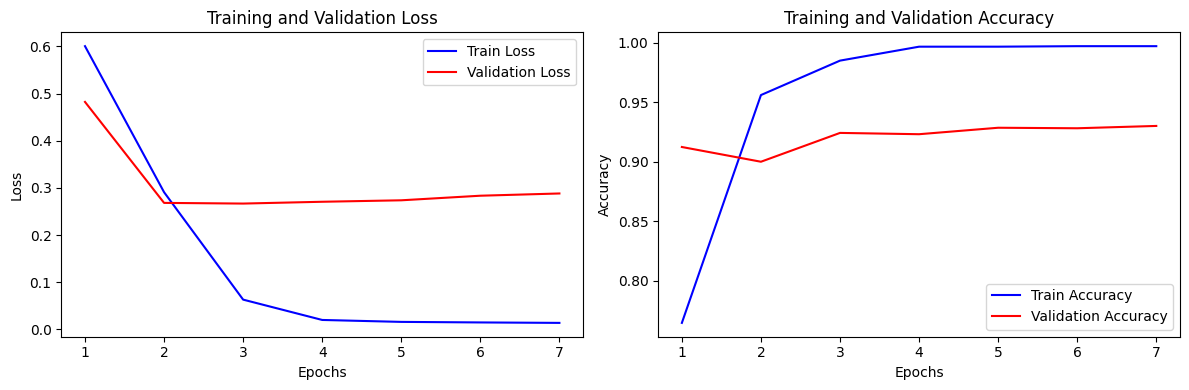

In [29]:
# Plot metrics
nepochs = range(1, len(train_losses) + 1)

# Loss plot
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(nepochs, train_losses, 'b-', label='Train Loss')
plt.plot(nepochs, val_losses, 'r-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(nepochs, train_accuracies, 'b-', label='Train Accuracy')
plt.plot(nepochs, val_accuracies, 'r-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [30]:
# define your model here
model = ViT(
    image_size = (1,1536),
    patch_size = (1,16),
    num_classes = 2,
    dim = 256,
    depth = 9,
    heads = 8,
    mlp_dim = 256,
    dropout = 0.1,
    emb_dropout = 0.1,
    channels=1
).to(device)

# Load the saved model state dictionary
saved_model_path = "/content/drive/MyDrive/histopathology/final_run/best_model_VIT.pt"
saved_model_state_dict = torch.load(saved_model_path)

# Load the saved model state dictionary into your model
model.load_state_dict(saved_model_state_dict)


<All keys matched successfully>

In [31]:
def compute_metrics(dataloader):
    model.eval()
    with torch.no_grad():
        all_preds, all_labels, all_losses = [], [], []
        for images, labels in tqdm(dataloader):
            images, labels = images.to(device), labels.to(device)
            preds = model(images)
            loss = criterion(preds, labels)
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
            all_losses.append(loss.item())
        all_preds = np.concatenate(all_preds)
        all_labels = np.concatenate(all_labels)
        all_losses = np.mean(all_losses)
        accuracy = accuracy_score(np.argmax(all_labels, axis=1), np.argmax(all_preds, axis=1))
        precision = precision_score(np.argmax(all_labels, axis=1), np.argmax(all_preds, axis=1))
        recall = recall_score(np.argmax(all_labels, axis=1), np.argmax(all_preds, axis=1))
        f1 = f1_score(np.argmax(all_labels, axis=1), np.argmax(all_preds, axis=1))
        fpr, tpr, _ = roc_curve(all_labels[:,1], all_preds[:,1])
        auc = roc_auc_score(all_labels[:,1], all_preds[:,1])
        cm = confusion_matrix(np.argmax(all_labels, axis=1), np.argmax(all_preds, axis=1))
        return all_preds, all_labels, all_losses, accuracy, precision, recall, f1, fpr, tpr, auc, cm


# Compute the metrics for train, test, and validation sets
train_preds, train_labels, train_loss, train_accuracy, train_precision, train_recall, train_f1, train_fpr, train_tpr, train_auc, train_cm = compute_metrics(train_loader)
test_preds, test_labels, test_loss, test_accuracy, test_precision, test_recall, test_f1, test_fpr, test_tpr, test_auc, test_cm = compute_metrics(test_loader)
val_preds, val_labels, val_loss, val_accuracy, val_precision, val_recall, val_f1, val_fpr, val_tpr, val_auc, val_cm = compute_metrics(val_loader)


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

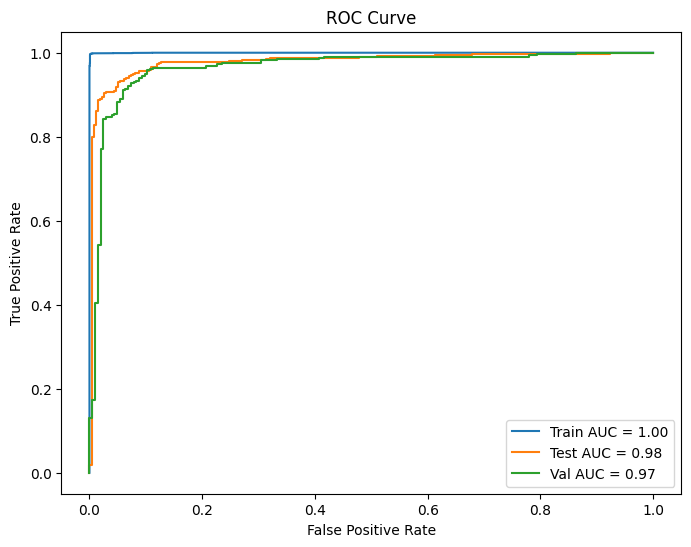

In [32]:
#Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(train_fpr, train_tpr, label=f"Train AUC = {train_auc:.2f}")
plt.plot(test_fpr, test_tpr, label=f"Test AUC = {test_auc:.2f}")
plt.plot(val_fpr, val_tpr, label=f"Val AUC = {val_auc:.2f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

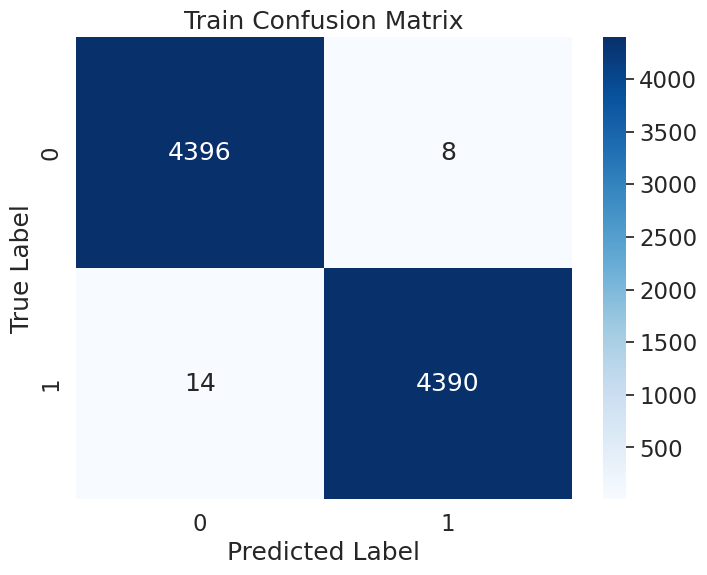

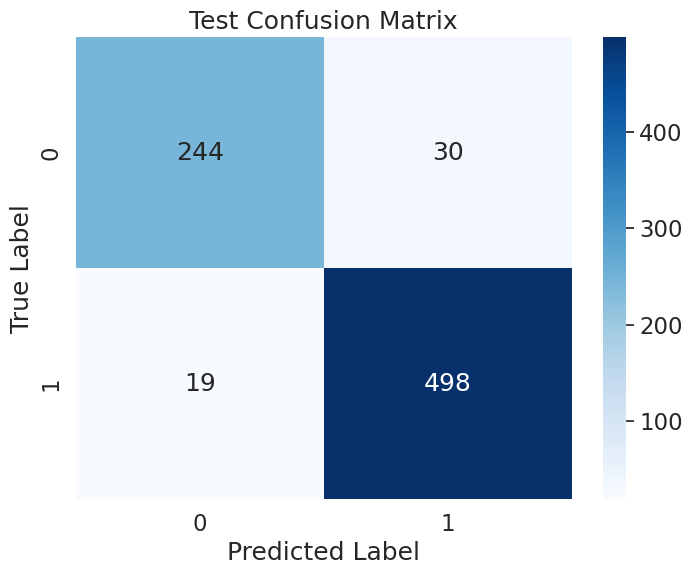

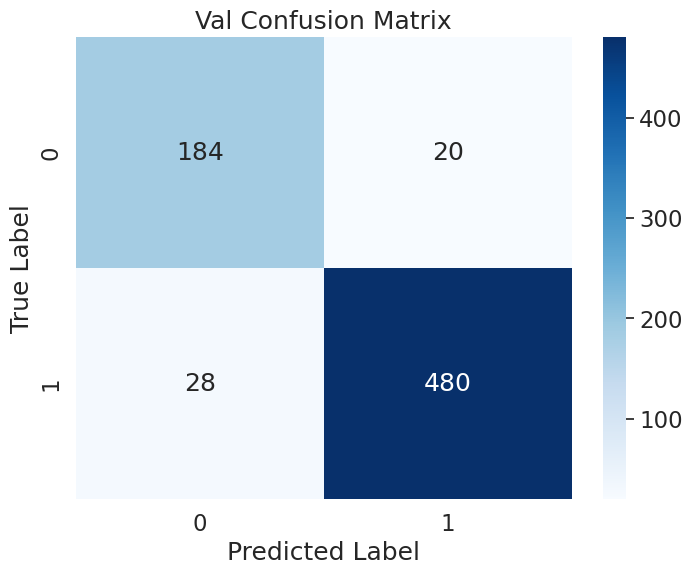

In [33]:
#Plot the confusion matrix
sns.set(font_scale=1.5)
plt.figure(figsize=(8, 6))
sns.heatmap(train_cm, annot=True, fmt="d", cmap="Blues")
plt.title("Train Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

sns.set(font_scale=1.5)
plt.figure(figsize=(8, 6))
sns.heatmap(test_cm, annot=True, fmt="d", cmap="Blues")
plt.title("Test Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

sns.set(font_scale=1.5)
plt.figure(figsize=(8, 6))
sns.heatmap(val_cm, annot=True, fmt="d", cmap="Blues")
plt.title("Val Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [34]:
#Print the metrics for train, test, and validation sets
print(f"Train Loss: {train_loss:.4f}")
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Train Precision: {train_precision:.4f}")
print(f"Train Recall: {train_recall:.4f}")
print(f"Train F1 Score: {train_f1:.4f}")
print(f"Train AUC: {train_auc:.4f}\n")

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")
print(f"Test AUC: {test_auc:.4f}\n")

print(f"Val Loss: {val_loss:.4f}")
print(f"Val Accuracy: {val_accuracy:.4f}")
print(f"Val Precision: {val_precision:.4f}")
print(f"Val Recall: {val_recall:.4f}")
print(f"Val F1 Score: {val_f1:.4f}")
print(f"Val AUC: {val_auc:.4f}\n")

Train Loss: 0.0158
Train Accuracy: 0.9975
Train Precision: 0.9982
Train Recall: 0.9968
Train F1 Score: 0.9975
Train AUC: 0.9999

Test Loss: 0.3314
Test Accuracy: 0.9381
Test Precision: 0.9432
Test Recall: 0.9632
Test F1 Score: 0.9531
Test AUC: 0.9793

Val Loss: 0.3850
Val Accuracy: 0.9326
Val Precision: 0.9600
Val Recall: 0.9449
Val F1 Score: 0.9524
Val AUC: 0.9655

